# Person of Interest Identifier 2.0 Part II
### ~Abhishek Singh

This is the continuation from Part I where we made our data ready to build our POI classifier. In this section we try different techniques to build this classifier with an aim to detect fraudulent activities.

In [1]:
#Importing dependencies
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from numpy.random import seed
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import pickle as pkl
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow_core.estimator import inputs
import tensorflow_hub as hub
from eval_metrics import f1_m,precision_m, recall_m

Using TensorFlow backend.


In [2]:
#Reading our pre-processed data
emails_df = pd.read_csv('cleaned_emails.csv')
if 'Unnamed: 0' in emails_df.columns:
    emails_df.drop('Unnamed: 0',axis=1,inplace=True)

A big issue in this case is that our data is highly skewed which can be seen by the following countplot

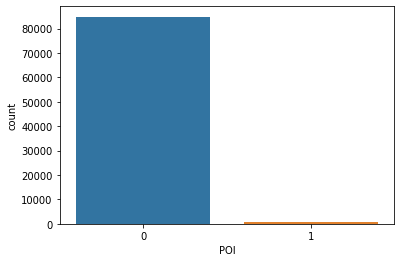

In [3]:
sns.countplot(emails_df['POI'])
plt.show()

To fix this we have to select data points of the negative class(POI=0) which can be used to train our classifier. However, instead of randomly selecting data points, we use a different strategy to obtain a respresentative samples of non-POI emails.
Rather than sampling directly since these emails belong to Enron employees, we take a small sample from all emails sent by an employee and we do this for every employee. This results in a sample with equal proportion of emails from all employees. We implement this below.

In [4]:
print('No. of unique sender:',len(emails_df[emails_df['POI']==0]['Sender'].unique())) #4505
neg_ind=[] #list to store sample of negative indexes
#for all unique employees who have sent an email, select an email to include in our data
for i in emails_df.loc[emails_df['POI']==0,'Sender'].unique(): 
    neg_ind.append(emails_df[(emails_df['Sender']==i) & (emails_df['POI']==0)].sample(1,random_state=27).index[0])
ind = neg_ind+list(emails_df[emails_df['POI']==1].index) #complete sample
df = emails_df.iloc[ind,2:]
df.dropna(inplace=True)

No. of unique sender: 4515


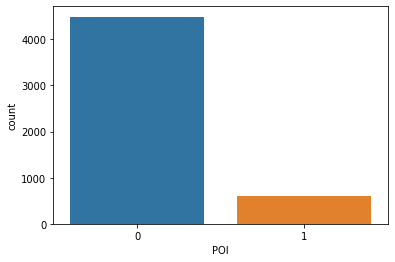

In [5]:
sns.countplot(df['POI'])
plt.show()

As a result we still have class imbalance however far lesser than before, we can now use this to train our model.

In [6]:
df.head()

,Month,Year,Sender,Receiver,Email,POI,Date,Folder,Length
9802,Jul,2000.0,mark.taylor@enron.com,craig.clark@enron.com,fcochran mark craig annmari tiller brent vasco...,0,2000-07-28 04:34:00,all_documents,656
46274,Jun,2001.0,christian.yoder@enron.com,jan.king@enron.com,pleas print doc sara pat send anoth case soon ...,0,2001-06-05 11:24:00,all_documents,58
2513,Jan,2000.0,mark.elliott@enron.com,bob.crane@enron.com,bob martin holm steve kim mark taylor paul sim...,0,2000-01-31 04:47:00,archive,727
54,May,1999.0,team.san-juan-laplata@enron.com,larry.campbell@enron.com,follow descript explan violat occur la plata c...,0,1999-05-03 09:32:00,discussion_threads,63
41,Apr,1999.0,leo.nichols@enron.com,larry.campbell@enron.com,know data find john woodyardroy clayton road s...,0,1999-04-05 00:33:00,all_documents,100


#### First approach - Machine Learning
We start by trying convetional ML algorithms to build our classifier

In [7]:
#To use our emails text we first have to vectorize it
#In this case we use a hashing vectorizer which hashes all the characters in buckets
vectorizer = HashingVectorizer(n_features=2**8) #set size of bucket(256)
X = vectorizer.fit_transform(df['Email']) #transform emails

In [8]:
#Train-test split
#We take into account class imbalance by building a stratified split
X_train, X_t, y_train, y_t = train_test_split(X,df['POI'].values,train_size=0.6,stratify= df['POI'].values,random_state=27)
X_valid, X_test, y_valid, y_test = train_test_split(X_t,y_t,train_size=0.5,stratify=y_t,random_state=27)

Logistic Regression

In [9]:
#Tuned paramters
lr = LogisticRegression(random_state=27,penalty='l1',class_weight='balanced',solver='saga',C=(1/0.8),n_jobs=-1)
lr.fit(X_train, y_train)

LogisticRegression(C=1.25, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=-1, penalty='l1',
                   random_state=27, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [10]:
y_pred = lr.predict(X_valid)
target_names = ['Non-POI', 'POI']
print(classification_report(y_valid, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     Non-POI       0.91      0.93      0.92       898
         POI       0.36      0.31      0.33       121

    accuracy                           0.85      1019
   macro avg       0.63      0.62      0.62      1019
weighted avg       0.84      0.85      0.85      1019



Random Forest

In [11]:
rfc = RandomForestClassifier(max_depth=12,n_estimators=250,max_features='log2',n_jobs=-1,class_weight='balanced',
                             random_state=27)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=12, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=-1, oob_score=False, random_state=27, verbose=0,
                       warm_start=False)

In [12]:
y_treepred = rfc.predict(X_valid)
target_names = ['Non-POI', 'POI']
print(classification_report(y_valid, y_treepred, target_names=target_names))

              precision    recall  f1-score   support

     Non-POI       0.92      0.85      0.88       898
         POI       0.30      0.49      0.37       121

    accuracy                           0.80      1019
   macro avg       0.61      0.67      0.63      1019
weighted avg       0.85      0.80      0.82      1019



#### Second approach - ANN using only Emails(keras)
In this approach we build a ANN model using only text features from Emails as before

In [13]:
#Data used here is a similar sample like one constructed before
#however the text here has not been stemmed as we use embeddings
df = pd.read_csv('cleaned_emails_v2_sample.csv') #without stemming
if 'Unnamed: 0' in df.columns:
    df.drop('Unnamed: 0',axis=1,inplace=True)
    
seed(27)
tf.random.set_seed(27)

In [14]:
#Stratified Train-test split
X_train, X_t, y_train, y_t = train_test_split(df['Email'].values,df['POI'].values,train_size=0.6,stratify= df['POI'].values,
                                              random_state=27)
X_valid, X_test, y_valid, y_test = train_test_split(X_t,y_t,train_size=0.5,stratify=y_t,random_state=27)

We build an embedding layer which transforms text features into actual real numbers.
These mappings can be learnt from the data itself or available mappings for texts can be used as is. They map text such that words with similar meaning end up close to each other when projected using these embeddings.

In [15]:
#Embedding layer
embedding = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1"
hub_layer = hub.KerasLayer(embedding, input_shape=[], dtype=tf.string, trainable=True)
hub_layer(df['Email'][:3]) #Emails transformed into arrays

<tf.Tensor: id=177, shape=(3, 20), dtype=float32, numpy=
array([[-0.0690988 , -1.2675935 ,  1.0311586 ,  0.7642924 , -1.629991  ,
        -1.583989  , -0.5602671 ,  0.64905256, -0.89884424,  0.03109733,
        -1.1423014 ,  0.6040384 ,  0.1921743 ,  0.05076366, -1.792022  ,
         1.3703084 ,  3.3514085 , -0.66031533, -0.52611065, -0.05823308],
       [ 0.03496719, -1.5895993 ,  0.9304886 ,  0.26502314, -1.8791146 ,
        -1.0367429 , -0.7065219 ,  0.4664881 ,  0.84767896,  0.07823891,
        -1.4019903 ,  0.4040001 ,  0.02059706,  0.3288846 , -1.2730055 ,
         0.49841094,  1.3465902 , -0.7286868 , -0.77458346, -0.4197046 ],
       [ 0.04950552, -1.7985698 ,  3.5081844 ,  4.531414  , -0.9298033 ,
        -3.4525535 ,  0.6759118 ,  1.7517952 , -0.8342227 , -0.2107257 ,
        -0.29104224,  0.6120026 , -2.2133074 ,  1.0173491 , -0.24392878,
         1.5154071 ,  5.400674  , -2.08155   ,  0.17594421, -1.3164209 ]],
      dtype=float32)>

In [16]:
#Model
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(10, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 20)                400020    
_________________________________________________________________
dense (Dense)                (None, 10)                210       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 400,241
Trainable params: 400,241
Non-trainable params: 0
_________________________________________________________________


In [17]:
#Tuned paramters
model.compile(optimizer='adam',
              learning_rate=0.05,
              loss='binary_crossentropy',
              metrics=['accuracy',f1_m],
             seed=27)

In [18]:
#Training our model
model.fit(X_train, y_train,
                    epochs=50,
                    validation_data=(X_valid,y_valid),
                    batch_size=128,
                    verbose=2)

Train on 3067 samples, validate on 1022 samples
Epoch 1/50
3067/3067 - 2s - loss: 0.7400 - accuracy: 0.5797 - f1_m: 0.1694 - val_loss: 0.5159 - val_accuracy: 0.7769 - val_f1_m: 0.1383
Epoch 2/50
3067/3067 - 0s - loss: 0.4588 - accuracy: 0.8200 - f1_m: 0.1170 - val_loss: 0.4321 - val_accuracy: 0.8513 - val_f1_m: 0.0524
Epoch 3/50
3067/3067 - 0s - loss: 0.4112 - accuracy: 0.8582 - f1_m: 0.0761 - val_loss: 0.4178 - val_accuracy: 0.8620 - val_f1_m: 0.0424
Epoch 4/50
3067/3067 - 0s - loss: 0.3966 - accuracy: 0.8683 - f1_m: 0.0769 - val_loss: 0.4091 - val_accuracy: 0.8669 - val_f1_m: 0.0430
Epoch 5/50
3067/3067 - 0s - loss: 0.3856 - accuracy: 0.8725 - f1_m: 0.0651 - val_loss: 0.4016 - val_accuracy: 0.8669 - val_f1_m: 0.0304
Epoch 6/50
3067/3067 - 1s - loss: 0.3758 - accuracy: 0.8735 - f1_m: 0.0768 - val_loss: 0.3938 - val_accuracy: 0.8689 - val_f1_m: 0.0310
Epoch 7/50
3067/3067 - 0s - loss: 0.3662 - accuracy: 0.8745 - f1_m: 0.0757 - val_loss: 0.3871 - val_accuracy: 0.8699 - val_f1_m: 0.0317


In [19]:
# model.save("model.h5")
print("Saved model to disk")

Saved model to disk


The main purpose of this model was to use it in the web-app developed, where this model is used to make predictions on the go on text inputs given through the app. It predicts if the given input resembles a fraudulent POI email.

#### Third approach - ANN with other features along with email(Tensorflow)
In this approach we build a hybrid model using other features with emails

In [20]:
features = df[['Length','Month','Folder','Email']]
target = df['POI']

In [21]:
#Stratified train-test split
X_train, X_valid, y_train, y_valid = train_test_split(features,target,train_size=0.7,stratify= df['POI'].values,
                                              random_state=27)

In [22]:
#train and test input functions
train_input_fn = tf.compat.v1.estimator.inputs.pandas_input_fn(X_train,y_train,shuffle=True, num_epochs=10, batch_size=128)
test_input_fn = tf.compat.v1.estimator.inputs.pandas_input_fn(X_valid,y_valid, shuffle=False, batch_size=1)

In [23]:
#Constructing feature columns
feature_columns=[]
feature_columns.append(tf.feature_column.numeric_column('Length')) # numeric coln length

month = tf.feature_column.categorical_column_with_vocabulary_list('Month', ['Jun', 'Feb', 'Jan', 
                                                                        'May', 'Apr', 'Nov', 
                                                                        'Sep', 'Jul', 'Mar',
                                                                        'Oct', 'Aug', 'Dec'])
month_one_hot = tf.feature_column.indicator_column(month)
feature_columns.append(month_one_hot)

#embedding coln folder with vocab list
folder = tf.feature_column.categorical_column_with_vocabulary_list('Folder',list(df['Folder'].unique()))
folder_embedding = tf.feature_column.embedding_column(folder, dimension=33)
feature_columns.append(folder_embedding)

#Text coln emails
embedded_text_feature_column = hub.text_embedding_column(key="Email",module_spec="https://tfhub.dev/google/nnlm-en-dim128/1")
feature_columns.append(embedded_text_feature_column)

In [24]:
#Building our model
estimator = tf.estimator.DNNClassifier(
    hidden_units=[16, 32],
    feature_columns=feature_columns,
    n_classes=2,
    optimizer = 'Adam', 
    model_dir='./output1')

INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': './output1', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000020F989DE408>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': './output1', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000020F989DE408>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [25]:
estimator.train(input_fn=train_input_fn, steps=1e5)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


Instructions for updating:
To construct input pipelines, use the `tf.data` module.


Instructions for updating:
To construct input pipelines, use the `tf.data` module.


Instructions for updating:
To construct input pipelines, use the `tf.data` module.


Instructions for updating:
To construct input pipelines, use the `tf.data` module.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.


Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.


Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.


Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.


Instructions for updating:
Use `tf.cast` instead.


Instructions for updating:
Use `tf.cast` instead.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from ./output1\model.ckpt-800


INFO:tensorflow:Restoring parameters from ./output1\model.ckpt-800


Instructions for updating:
Use standard file utilities to get mtimes.


Instructions for updating:
Use standard file utilities to get mtimes.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Instructions for updating:
To construct input pipelines, use the `tf.data` module.


Instructions for updating:
To construct input pipelines, use the `tf.data` module.


INFO:tensorflow:Saving checkpoints for 800 into ./output1\model.ckpt.


INFO:tensorflow:Saving checkpoints for 800 into ./output1\model.ckpt.


INFO:tensorflow:loss = 0.22440484, step = 800


INFO:tensorflow:loss = 0.22440484, step = 800


INFO:tensorflow:global_step/sec: 78.417


INFO:tensorflow:global_step/sec: 78.417


INFO:tensorflow:loss = 0.24366504, step = 900 (1.280 sec)


INFO:tensorflow:loss = 0.24366504, step = 900 (1.280 sec)


INFO:tensorflow:global_step/sec: 66.9346


INFO:tensorflow:global_step/sec: 66.9346


INFO:tensorflow:loss = 0.24436885, step = 1000 (1.496 sec)


INFO:tensorflow:loss = 0.24436885, step = 1000 (1.496 sec)


INFO:tensorflow:Saving checkpoints for 1080 into ./output1\model.ckpt.


INFO:tensorflow:Saving checkpoints for 1080 into ./output1\model.ckpt.


INFO:tensorflow:Loss for final step: 0.25517416.


INFO:tensorflow:Loss for final step: 0.25517416.


In [26]:
#Evaluating on test data
report = estimator.evaluate(test_input_fn)

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-01-09T17:29:44Z


INFO:tensorflow:Starting evaluation at 2020-01-09T17:29:44Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from ./output1\model.ckpt-1080


INFO:tensorflow:Restoring parameters from ./output1\model.ckpt-1080


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-01-09-17:29:53


INFO:tensorflow:Finished evaluation at 2020-01-09-17:29:53


INFO:tensorflow:Saving dict for global step 1080: accuracy = 0.91525424, accuracy_baseline = 0.88135594, auc = 0.873663, auc_precision_recall = 0.63125736, average_loss = 0.23841691, global_step = 1080, label/mean = 0.118644066, loss = 0.23841691, precision = 0.6666667, prediction/mean = 0.138258, recall = 0.5714286


INFO:tensorflow:Saving dict for global step 1080: accuracy = 0.91525424, accuracy_baseline = 0.88135594, auc = 0.873663, auc_precision_recall = 0.63125736, average_loss = 0.23841691, global_step = 1080, label/mean = 0.118644066, loss = 0.23841691, precision = 0.6666667, prediction/mean = 0.138258, recall = 0.5714286


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1080: ./output1\model.ckpt-1080


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1080: ./output1\model.ckpt-1080


In [27]:
#performance of hybrid model on test
report

{'accuracy': 0.91525424,
 'accuracy_baseline': 0.88135594,
 'auc': 0.873663,
 'auc_precision_recall': 0.63125736,
 'average_loss': 0.23841691,
 'label/mean': 0.118644066,
 'loss': 0.23841691,
 'precision': 0.6666667,
 'prediction/mean': 0.138258,
 'recall': 0.5714286,
 'global_step': 1080}

From our analysis we conclude that the hybrid model with other features with emails outperforms others. We have successfully built a POI identifier which classifies POI emails. Such classifiers can be used to identify fraudulent activities saving coorporations thousands of dollars. 

The web-app developed for the project can be found [here](https://poi-identifier.herokuapp.com/)
The app is divided into two sections, one for descriptive statistics to get a preview of the data and the second one for predictions which takes user input and classifies it as POI/non-POI. 